In [2]:
from preprocess import *
from DANN_CNN import *
import torch
import torch.nn as nn
import math
from torch.autograd import Function
from collections import Counter
import itertools

data_list = load_data()

In [3]:
X_all = []
Y_class = []
Y_domain = []

for i in range(12):
    [X, Y] = data_list[i]
    X = get_CNN_data(X)
    X_all.append(X)
    Y_class.append(Y)
    Y_domain.append(np.full(X.shape[0], i))

X_all = np.concatenate(X_all)
Y_class = np.concatenate(Y_class)
Y_domain = np.concatenate(Y_domain)
assert(X_all.shape[0] == Y_domain.shape[0])

In [4]:
def dann_lambda(epoch, max_epoch, max_lambda=0.5):
    p = epoch / max_epoch

    lam = 2.0 / (1.0 + math.exp(-10 * p)) - 1.0
    lam = lam * max_lambda

    # if epoch < 2:
    #     lam = 0.0

    return lam


batch_size = 32
lr = 1e-3
epochs = 20
patience = 5

acc_list = []

for i in [2]:
# for i in range(12):
    print(f"This is person {i}")

    model = DANN(num_classes=3, num_domains=2).cuda()
    criterion_class = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_domain = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    mask1 = Y_domain != i
    mask2 = Y_domain == i

    X_train = X_all[mask1]
    Y_class_train = Y_class[mask1]
    Y_domain_train = Y_domain[mask1] == i

    X_test = X_all[mask2]
    Y_class_test = Y_class[mask2]
    Y_domain_test = Y_domain[mask2] == i
    
    train_dataset = DANNDataset(X_train, Y_class_train, Y_domain_train)
    test_dataset = DANNDataset(X_test, Y_class_test, Y_domain_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    target_iter = itertools.cycle(test_loader)

    train_acc_list = []
    domain_acc_list = []
    test_acc_list = []

    
    best_test_acc = 0
    bad_epochs = 0

    for epoch in range(epochs):
        p = float(epoch) / epochs
        lambd = dann_lambda(epoch, epochs)
        model.train()

        correct_train = 0
        correct_domain = 0
        correct_test = 0    
        domain_cnt = 0    

        for x, y_c, y_d in train_loader:

            x, y_c, y_d = x.cuda(), y_c.cuda(), y_d.cuda()
            x_t, _, y_t = next(target_iter)
            x_t, y_t = x_t.cuda(), y_t.cuda()

            optimizer.zero_grad()

            class_out, domain_out = model(x, lambd)
            loss_c = criterion_class(class_out, y_c)
            loss_d = criterion_domain(domain_out, y_d)

            pred = domain_out.argmax(dim=1)
            correct_domain += (pred == y_d).sum().item()
            domain_cnt += x.shape[0]

            _, domain_out = model(x_t, lambd)
            loss_t = criterion_domain(domain_out, y_t)

            pred = domain_out.argmax(dim=1)
            correct_domain += (pred == y_t).sum().item()
            domain_cnt += x_t.shape[0]

            loss = loss_c + (loss_d * x.shape[0] + loss_t * x_t.shape[0]) / (x.shape[0] + x_t.shape[0])
            loss.backward()
            optimizer.step()

            pred = class_out.argmax(dim=1)
            correct_train += (pred == y_c).sum().item()
            

        model.eval()

        with torch.no_grad():
            for x, y, _ in test_loader:
                x, y = x.cuda(), y.cuda()
                class_out, _ = model(x)
                loss = criterion_class(class_out, y)

                pred = class_out.argmax(dim=1)
                correct_test += (pred == y).sum().item()

        train_acc = correct_train / len(train_dataset)
        domain_acc = correct_domain / domain_cnt
        test_acc = correct_test / len(test_dataset)
        print(f"epoch {epoch+1}: train_acc = {train_acc}, domain_acc = {domain_acc} test_acc = {test_acc}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            bad_epochs = 0
            best_weights = model.state_dict()
        # else:
        #     bad_epochs += 1
        #     if bad_epochs >= patience:
        #         print("Early stopping!")
        #         break
    
    acc_list.append(best_test_acc)

    
    

This is person 2
epoch 1: train_acc = 0.7526452170157634, domain_acc = 0.8154646224717483 test_acc = 0.4770387965162312
epoch 2: train_acc = 0.885337939969769, domain_acc = 0.7754444684373425 test_acc = 0.5403800475059383
epoch 3: train_acc = 0.9355790685956957, domain_acc = 0.6888540991866408 test_acc = 0.5277117973079969
epoch 4: train_acc = 0.9612754624631109, domain_acc = 0.6315770531922551 test_acc = 0.7478226444972288
epoch 5: train_acc = 0.9786943064852803, domain_acc = 0.6043691067444037 test_acc = 0.735550277117973
epoch 6: train_acc = 0.9835528683509681, domain_acc = 0.5817318073850141 test_acc = 0.6088677751385589
epoch 7: train_acc = 0.9864320161232275, domain_acc = 0.6088677751385589 test_acc = 0.721298495645289
epoch 8: train_acc = 0.989167206506874, domain_acc = 0.5351615921687181 test_acc = 0.614806017418844
epoch 9: train_acc = 0.9930540559994242, domain_acc = 0.4984164687252573 test_acc = 0.564528899445764
epoch 10: train_acc = 0.9906787590873102, domain_acc = 0.52047

In [5]:
torch.save(best_weights, "best_dann_uda_weights.pth")

[0.6274742676167855, 0.8072050673000791, 0.8661916072842438, 0.7636579572446556, 0.6528107680126682, 0.8950910530482977, 0.9350752177355502, 0.7026920031670626, 0.9303246239113222, 0.5217735550277118, 0.8440221694378464, 0.7751385589865399]
LOSO Mean Accuracy: 0.7768, Std: 0.1240


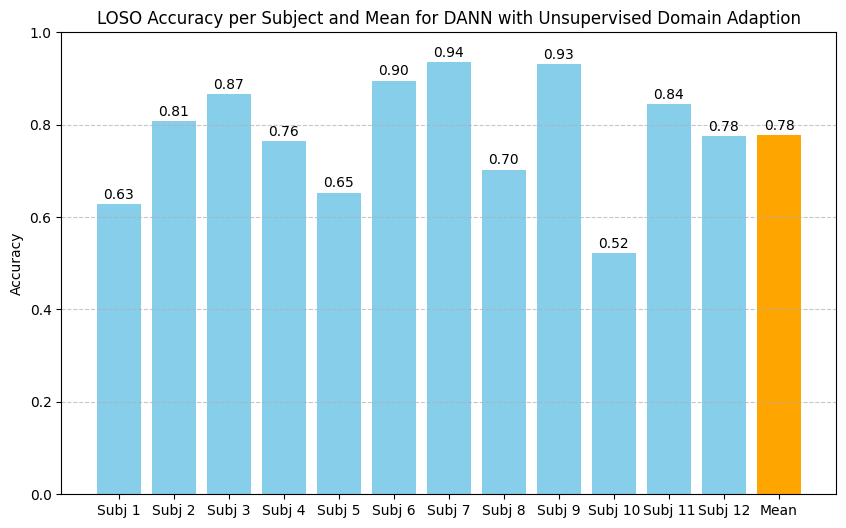

In [27]:
print(acc_list)
mean_acc = np.mean(acc_list)
std_acc = np.std(acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for DANN with Unsupervised Domain Adaption")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

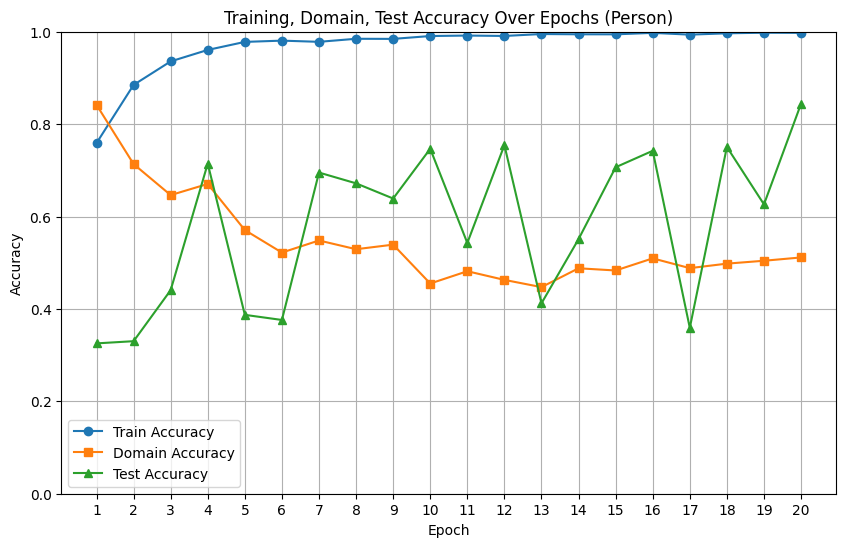

In [28]:
import matplotlib.pyplot as plt

# 数据
epochs = list(range(1, 21))  # 1-base

train_acc = [
    0.7589073634204275, 0.8848700784567768, 0.9357950046786151, 0.9605916648671993,
    0.9779745195422155, 0.9807097099258619, 0.9781184769308284, 0.9847405168070251,
    0.9844885913769524, 0.9906787590873102, 0.9917224501547542, 0.9908227164759231,
    0.9949974807456993, 0.9944216511912474, 0.994349672496941, 0.9975167350464262,
    0.9936658749010293, 0.9965810120204419, 0.9978406391708055, 0.9975527243935794
]

domain_acc = [
    0.8417908299143454, 0.7135427913337652, 0.6463686748722378, 0.670499532138487,
    0.5706650831353919, 0.5219714964370546, 0.548135751817462, 0.529223349888433,
    0.5391024256819982, 0.4549953213848701, 0.4815914489311164, 0.46284099906427695,
    0.44718563305261644, 0.48797955805081694, 0.4831929748794357, 0.5094292089541496,
    0.4882674728280429, 0.49802058590657167, 0.5042647376376592, 0.511408623047578
]

test_acc = [
    0.3254156769596199, 0.33016627078384797, 0.44061757719714967, 0.7145684877276326,
    0.38717339667458434, 0.3760886777513856, 0.6951702296120348, 0.6718131433095804,
    0.6389548693586699, 0.7466349960411718, 0.5427553444180523, 0.7545526524148852,
    0.41211401425178146, 0.5510688836104513, 0.7066508313539193, 0.7422802850356295,
    0.3590657165479018, 0.7505938242280285, 0.6262866191607285, 0.8440221694378464
]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, domain_acc, marker='s', label='Domain Accuracy')
plt.plot(epochs, test_acc, marker='^', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Domain, Test Accuracy Over Epochs (Person)")
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()
